# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [2]:
# read data
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", 
                  encoding="ISO-8859-1", 
                  na_values = [-999])

dat_clean = (dat.rename(columns={ # rename diet related columns with whitespace
            'Diet: invertebrates': 'Diet_Invertebrates',
            'Diet: vertebrates': 'Diet_Vertebrates',
            'Diet: fruits': 'Diet_Fruits',
            'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
            'Diet: seeds': 'Diet_Seeds',
            'Diet: other plant materials': 'Diet_Plants',
            'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
        })
             .loc[:, (dat.isna().sum(axis=0) <= dat.shape[0] * 0.4)]) # drop variables where > 40% is NA

print(f"Final DataFrame shape: {dat_clean.shape}")

Final DataFrame shape: (214, 17)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [3]:
def impute(df): 
    cats = df.select_dtypes(include=['object']) # select categoricals
    nums = dat_clean.select_dtypes(include = ['number']) # select continuous
    
    # impute categoricals vars with mode
    df[cats.columns] = df[cats.columns].fillna(cats.mode().iloc[0])
    
    # impute continuous vars wiith KNN
    imputer = KNNImputer(n_neighbors = 5)
    df[nums.columns] = imputer.fit_transform(df[nums.columns])
    
    return df

dat_imputed = impute(dat_clean.copy())

### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [4]:
# get all categorical variables
cats = dat_clean.select_dtypes(include=['object'])

# make a copy
dat_encoded = dat_imputed.copy()

# create total climates variable
dat_encoded['nClimates'] = dat_encoded['Dry'] + dat_encoded['Humid'] + dat_encoded['Montane'] + dat_encoded['Subarid'] + dat_encoded['Subhumid']

# drop individual climates
dat_encoded = dat_encoded.drop(columns = ['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'])

# encode categorical variables
for column in cats:
   dat_encoded[column] = LabelEncoder().fit_transform(cats[column])

In [5]:
# split predictor and target variables
y = dat_encoded['nClimates'].astype(np.int64)
x = dat_encoded.iloc[:, :-1]

# split data 70-30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

In [6]:
# init and fit decision tree model
tree_maker = DecisionTreeRegressor(max_depth = 5, random_state = 808).fit(x_train, y_train)

# make predictions on tree
tree_pred = tree_maker.predict(x_test)

In [7]:
# calc MSE
print(f'Decision tree MSE: {mean_squared_error(y_test, tree_pred):.2f}')

Decision tree MSE: 2.04


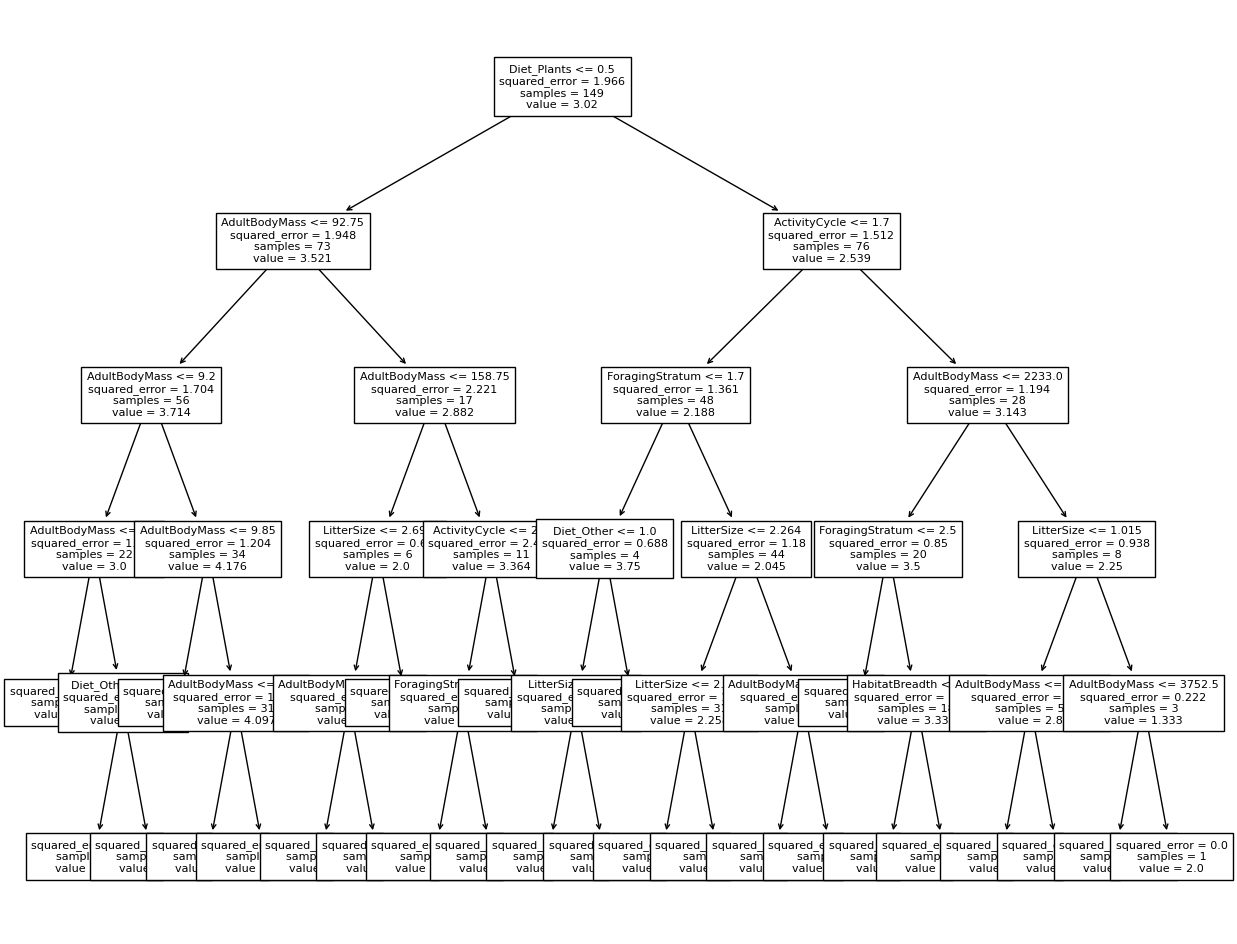

In [8]:
# set fig size
plt.rcParams['figure.figsize'] = [15, 12]

# generate visualization of tree
plot_tree(tree_maker, fontsize = 8, feature_names = x.columns);

Based on the way this tree looks, what would you guess the most important variable to be?

Most important variable is **Diet_Plants**, because trees tend to split by the most important variables first.

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [9]:
# set parameter value dict for grid
parameters = {
    'max_features': ('sqrt', 6, None),
    'n_estimators': (50, 100, 200), 
    'max_depth': (3, 4, 5, 6, 7), 
    'min_samples_split': (2, 5, 10),
    'min_samples_leaf': (1, 2, 4)
    
}

In [10]:
# iterate on all set parameter values to find optimal random forest model
best_rf = GridSearchCV(RandomForestRegressor(random_state = 808), parameters, cv = 5, scoring = 'neg_mean_squared_error').fit(x_train, y_train)

In [11]:
# format best estimator attribute
best_estims = str(best_rf.best_estimator_).replace('\n                      ', ' ')

print(f"Best estimators with associated values_______________________ \n\t{best_estims}")
print(f'Best negative MSE when trained on best estimators____________ \n\t{best_rf.best_score_}')
print(f'Best parameter values________________________________________ \n\t{best_rf.best_params_}')

Best estimators with associated values_______________________ 
	RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_split=5, random_state=808)
Best negative MSE when trained on best estimators____________ 
	-1.536470104397124
Best parameter values________________________________________ 
	{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [12]:
# predict climate habitability on random forest
forest_y_pred = best_rf.predict(x_test)

print(f'Best parameters: {best_rf.best_params_}')
print(f'Mean squared error of best random forest: {mean_squared_error(y_test, forest_y_pred):.2f}')

Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean squared error of best random forest: 1.47


In [13]:
# generate sorted table of feature importances
pd.DataFrame({
    'Feature': x.columns,
    'Importance': best_rf.best_estimator_.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

,Feature,Importance
0,AdultBodyMass,0.300409
11,LitterSize,0.160871
10,ForagingStratum,0.119273
9,ActivityCycle,0.077545
6,Diet_Plants,0.075022
8,HabitatBreadth,0.062598
4,Diet_Flowers,0.045216
2,Diet_Vertebrates,0.038079
1,Diet_Invertebrates,0.038013
3,Diet_Fruits,0.028626


Text(0.5, 1.0, 'Quantified Feature Importance in An Optimized Random Forest Model of \n Predicting Climate Habitability in Malagasy Mammals by Trait')

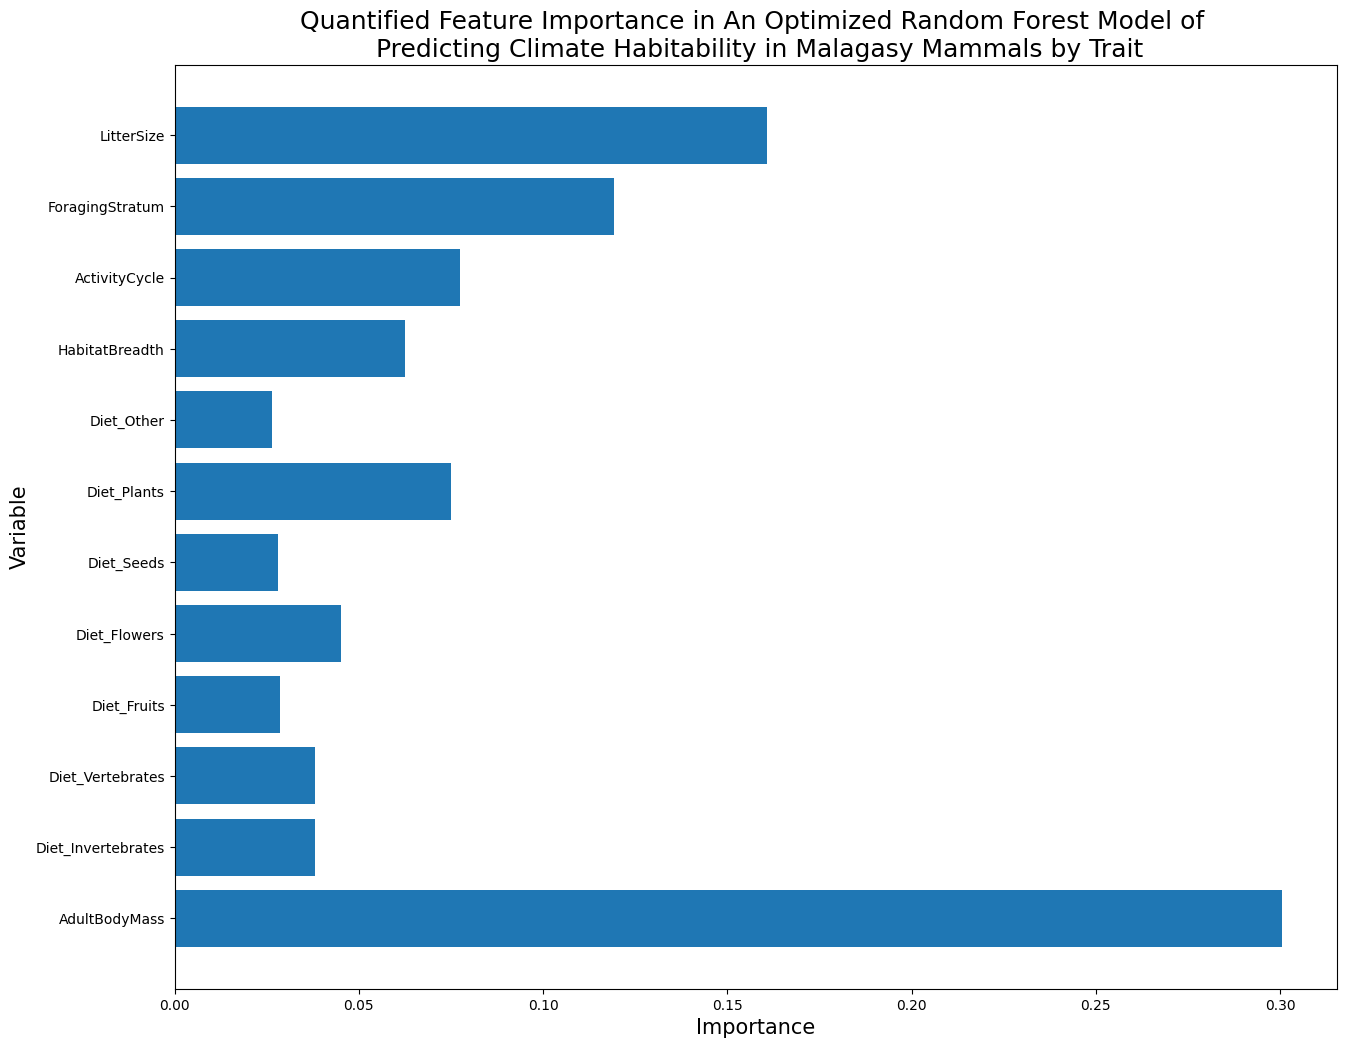

In [14]:
# feature importance horizontal bar plot
plt.barh(x.columns, best_rf.best_estimator_.feature_importances_)

plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Variable', fontsize = 15)
plt.title('Quantified Feature Importance in An Optimized Random Forest Model of \n Predicting Climate Habitability in Malagasy Mammals by Trait', fontsize = 18)

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

The ensemble had the largest accuracy, as it had a lower MSE. Most important trait was **adult body mass** by a very large margin at an importance of 0.3. Other notatable traits were **litter size** at 0.16, and **foraging stratum** at 0.12.